In [1]:
import joblib
import numpy as np

from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
import pandas as pd

import sys
sys.path.append('../')
from colorml.utils import mapping_to_target_range, get_timestamp_string, plot_predictions, huber_fn, mapping_to_target_range_sig, read_pickle, augment_data
from colorml.descriptornames import * 

Using TensorFlow backend.


In [7]:
get_custom_objects().update({'mapping_to_target_range': Activation(mapping_to_target_range)})

In [46]:
model = joblib.load('../../best_model.joblib')

In [22]:
from keras.utils import plot_model

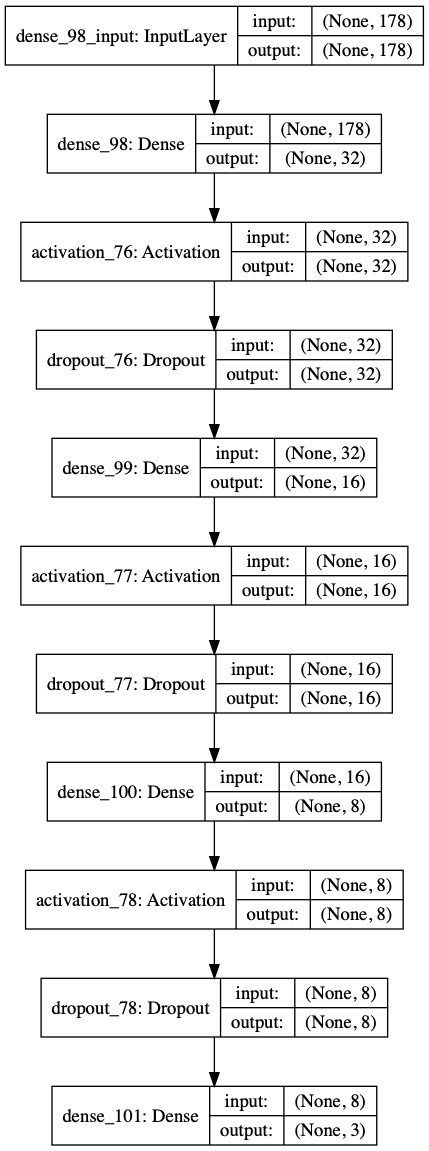

In [24]:
plot_model(model, expand_nested=True, show_shapes=True)

In [ ]:
model.

In [9]:
model.weights

[<tf.Variable 'dense_98_1/kernel:0' shape=(178, 32) dtype=float32, numpy=
 array([[ 0.05714735, -0.00082213,  0.0047286 , ..., -0.12749887,
         -0.00373052,  0.06062212],
        [-0.13739844,  0.00063132,  0.10532415, ...,  0.03518292,
         -0.04988083, -0.00524171],
        [ 0.073094  ,  0.01355302, -0.05616594, ..., -0.07996893,
         -0.29726285,  0.08574837],
        ...,
        [ 0.0938018 , -0.15974702,  0.00883035, ..., -0.2006726 ,
         -0.02604441, -0.08133423],
        [-0.29871365,  0.04970886,  0.0851801 , ..., -0.08257324,
         -0.10839073, -0.04649993],
        [-0.02621866,  0.14467494,  0.01676583, ...,  0.18771102,
          0.04149657,  0.14778356]], dtype=float32)>,
 <tf.Variable 'dense_98_1/bias:0' shape=(32,) dtype=float32, numpy=
 array([-0.00418837,  0.04359641,  0.04712363, -0.00262981,  0.04100492,
        -0.1289425 , -0.00090325, -0.02956641, -0.02745338,  0.04301456,
        -0.0392283 ,  0.04988199,  0.0020763 ,  0.04379445, -0.116128

In [37]:
df_train = pd.read_csv('../data/development_set.csv')
df_test = pd.read_csv('../data/holdout_set.csv')

In [339]:
df_subset_merged = pd.read_csv('../data/color_feat_merged.csv')

In [3]:
from sklearn.preprocessing import MinMaxScaler

In [4]:
scaler = MinMaxScaler()

In [5]:
CHEMICAL_FEATURES = (
        metalcenter_descriptors
        + functionalgroup_descriptors
        + linker_descriptors
        + mol_desc
        + summed_functionalgroup_descriptors
        + summed_linker_descriptors
        + summed_metalcenter_descriptors
    )

In [58]:
X_train = df_train[CHEMICAL_FEATURES]
X_test = df_test[CHEMICAL_FEATURES]

In [59]:
y_train = df_train[['r', 'g', 'b']]
y_test = df_test[['r', 'g', 'b']]

In [60]:
name_train = df_train['color_cleaned']

In [61]:
name_test = df_test['color_cleaned']

In [62]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Y_train = y_train / 255 -0.5
Y_test = y_test / 255 - 0.5

In [43]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.decomposition import PCA
from keras import Sequential
from keras.layers import Dense, Dropout
#from livelossplot.keras import PlotLossesCallback
from keras.constraints import MinMaxNorm
from keras.initializers import Constant
from keras.optimizers import Adam
from colorml.utils import mapping_to_target_range, read_pickle, get_timestamp_string, plot_predictions, huber_fn, mapping_to_target_range_sig
from livelossplot.keras import PlotLossesCallback

In [63]:
vt = PCA(25)
X_train = vt.fit_transform(X_train)
X_test = vt.transform(X_test)

# mm = MinMaxScaler()
# X_train = mm.fit_transform(X_train)
# X_test = mm.transform(X_test)

In [275]:
timestamp = get_timestamp_string()
mlp = Sequential()
mlp.add(Dense(32, activation="relu", 
              kernel_initializer='he_normal', input_shape=(X_train.shape[1],)))
mlp.add(Dropout(0.25))
mlp.add(Dense(16,  activation="relu", 
             kernel_initializer='he_normal'))  
mlp.add(Dropout(0.25))
mlp.add(Dense(8,  activation='relu', 
             kernel_initializer='he_normal'))
mlp.add(Dropout(0.25))
mlp.add(Dense(3, activation=mapping_to_target_range, kernel_initializer='he_normal'))


In [276]:
es = EarlyStopping(monitor='val_loss', patience=40, verbose=0, mode='auto')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=20, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

In [277]:
mlp.compile(optimizer=Adam(), loss=huber_fn, metrics=['mae', 'mean_absolute_percentage_error'])

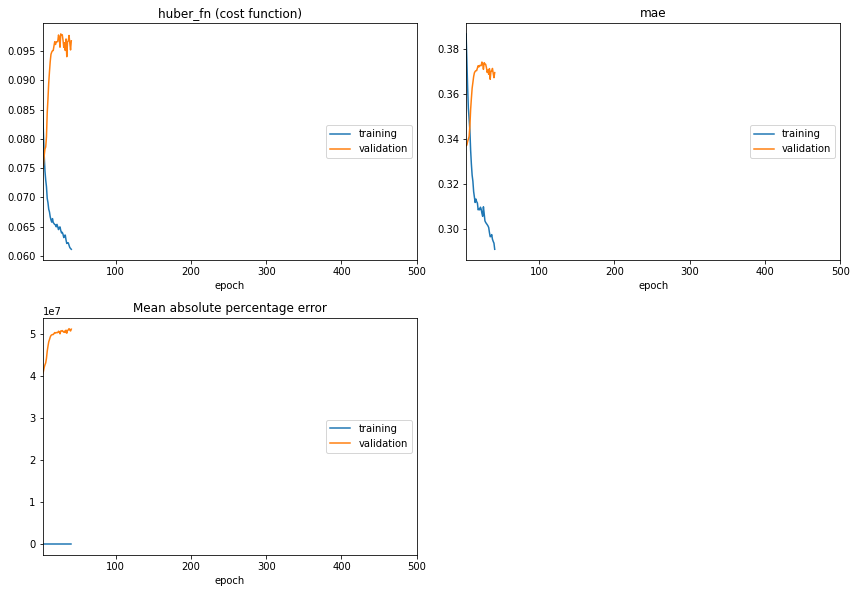

In [278]:
mlp.fit(X_train, Y_train.values, epochs=500, batch_size=264, 
        callbacks=[es, PlotLossesCallback(plot_extrema=False)], validation_split=0.2)

../colorml/utils.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


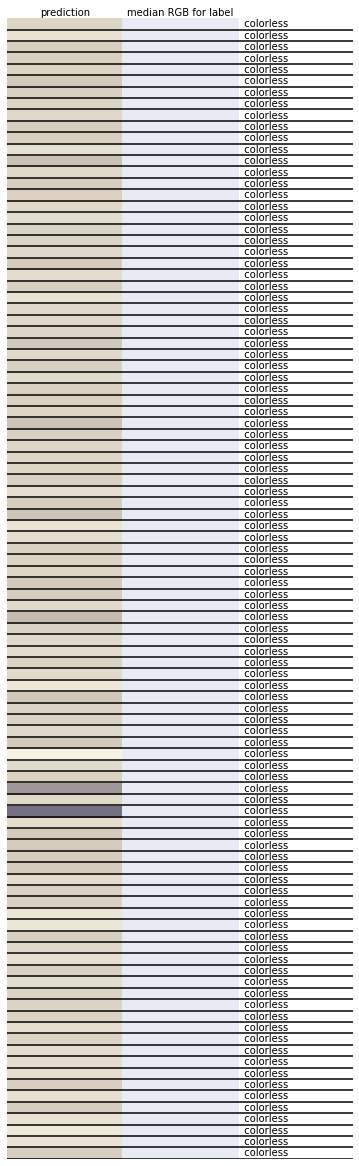

In [265]:
predictions = mlp.predict(X_train)

plot_predictions(predictions * 255, Y_train.values * 255,  name_train.values,  sample=100)

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline

In [232]:
knn = KNeighborsRegressor(3)
pipe = Pipeline(
    [   
        #('vt', VarianceThreshold(0.8)),
        ('knn', knn)
    ]
)
pipe.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('knn',
                 KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                     metric='minkowski', metric_params=None,
                                     n_jobs=None, n_neighbors=3, p=2,
                                     weights='uniform'))],
         verbose=False)

../colorml/utils.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


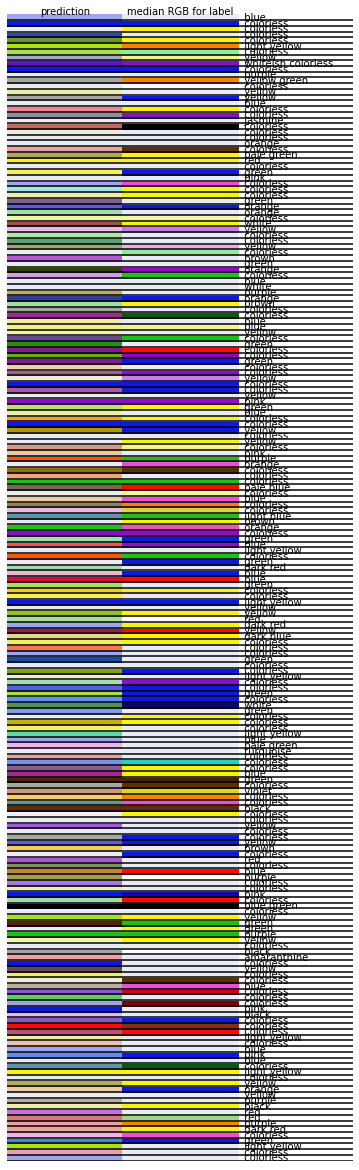

In [233]:
predictions = pipe.predict(X_test)

plot_predictions(predictions * 255, Y_test.values * 255,  name_train.values,  sample=200)

In [71]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,WhiteKernel,
                                              ConstantKernel as C)

In [81]:
gp_kernel =   Matern(0.4, (1e-3, 1e0)) +  WhiteKernel(0.1, (1e-3,.5e0)) + C(0, (1e-3,.5))
gp = GaussianProcessRegressor(kernel=gp_kernel, n_restarts_optimizer=9, normalize_y=True)

gp_pipe = Pipeline(
    [
        #('vt', VarianceThreshold(0.7)), 
        ('gp', gp)
    ]
)

gp_pipe.fit(X_train, Y_train)

/Users/kevinmaikjablonka/opt/miniconda3/envs/colorml/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:255: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


Pipeline(memory=None,
         steps=[('gp',
                 GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                                          kernel=Matern(length_scale=0.4, nu=1.5) + WhiteKernel(noise_level=0.1) + 0**2,
                                          n_restarts_optimizer=9,
                                          normalize_y=True,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)

In [20]:
gp_pipe

Pipeline(memory=None,
         steps=[('gp',
                 GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                                          kernel=RBF(length_scale=1) + 0**2,
                                          n_restarts_optimizer=9,
                                          normalize_y=True,
                                          optimizer='fmin_l_bfgs_b',
                                          random_state=None))],
         verbose=False)

In [82]:
joblib.dump(gp_pipe, 'gaussian_process_8_may_6.joblib')

['gaussian_process_8_may_6.joblib']

In [48]:
gp_pipe.steps[0]

('gp',
 GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                          kernel=RBF(length_scale=1), n_restarts_optimizer=9,
                          normalize_y=True, optimizer='fmin_l_bfgs_b',
                          random_state=None))

In [49]:
sample = gp_pipe.steps[0][1].sample_y(X_test, 200).reshape(200, 1, 1920, 3)

In [50]:
sample.shape

(200, 1, 1920, 3)

In [84]:
mu, std = gp_pipe.predict(X_test, return_std=True)

In [26]:
augment_dict = read_pickle('../data/augment_dict.pkl')

In [27]:
from colorml.utils import plot_prediction_dist

../colorml/utils.py:301: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


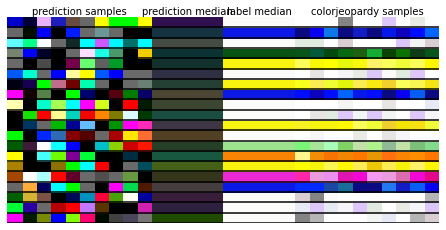

In [52]:
plot_prediction_dist(sample * 255 , name_test, augment_dict, 20, figsize=(6,3))

../colorml/utils.py:159: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


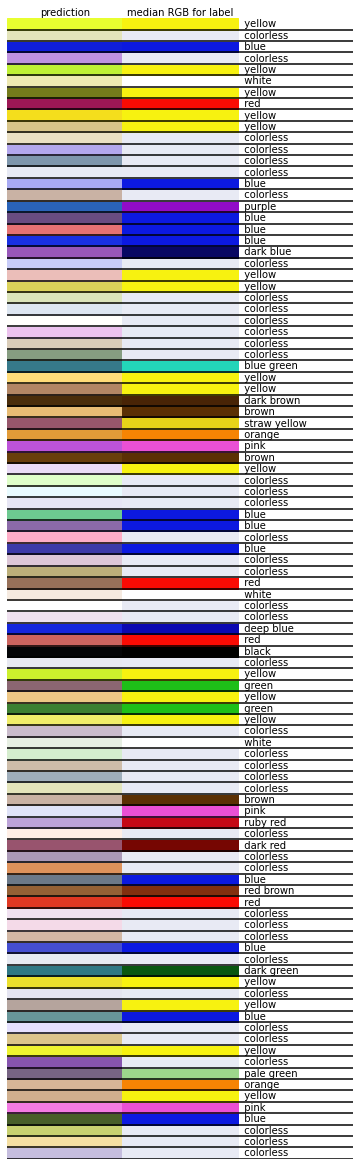

In [83]:
predictions = gp_pipe.predict(X_test)

plot_predictions((predictions + 0.5) * 255, (Y_test.values + 0.5) * 255,  name_test.values,  sample=100)